###setup

In [163]:
%matplotlib inline

In [164]:
from numpy import array, inf, maximum
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [166]:
from os.path import join, exists
from os import mkdir, makedirs
import pandas as pd

In [167]:
import regression

In [168]:
from skimage.io import imread, imsave

###set directory and session information

In [169]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [188]:
key = '2016-04-24'
name = 'anm-0330549-6'

In [189]:
path = join(directory, 'reprocessed', name, key)

In [190]:
pixelsPerUm = 600.0/256
frameRate = 1.9
scaleBar = 100

In [191]:
savepath = join(directory, 'reprocessed', name, key, 'summary')

###load covariates

In [192]:
covariates = pd.read_csv(join(path, 'covariates','covariates.csv'))

###load data

In [193]:
data = thunder.images.frombinary(join(path, 'images'), engine=sc, npartitions = 1000)

In [194]:
from numpy import arange, polyfit, polyval

In [195]:
def detrend(y, order=5):
        """
        Detrend series data with linear or nonlinear detrending.
        Preserve intercept so that subsequent operations can adjust the baseline.
        Parameters
        ----------
        method : str, optional, default = 'linear'
            Detrending method
        order : int, optional, default = 5
            Order of polynomial, for non-linear detrending only
        """

        x = arange(len(y))
        p = polyfit(x, y, order)
        p[-1] = 0
        yy = polyval(p, x)
        return y - yy

In [196]:
detrended = data.map_as_series(lambda x: detrend(x))

In [197]:
detrended.cache()
detrended.compute()

In [198]:
records = detrended.toseries()

In [199]:
records.cache()
records.compute()

In [200]:
avg = detrended.map(lambda x: x.mean()).toarray()

In [201]:
avg.shape

(3734,)

In [202]:
len(covariates)

3734

(0, 500)

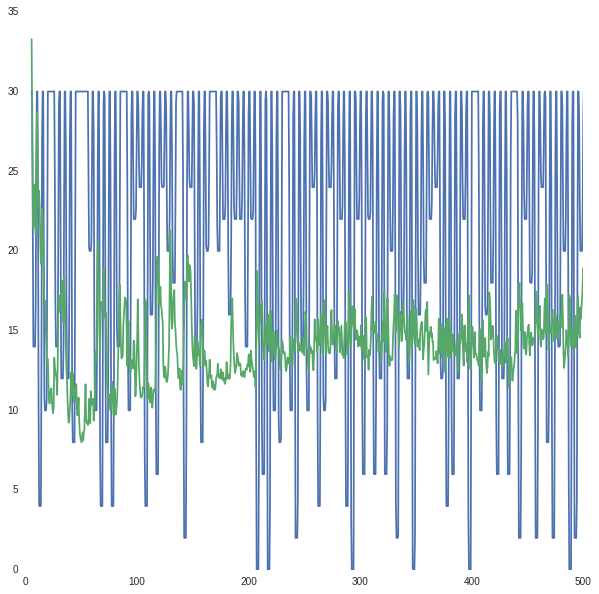

In [203]:
plt.figure(figsize=(10,10))
plt.plot(covariates.allTime, covariates.corPos);
plt.plot(covariates.allTime, avg/5-40);
plt.xlim([0, 500])

##Pixelwise regression demo

In [204]:
import numpy as np
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from regression import LinearRegression

In [205]:
def build_reg(value, scale, debug=False):
    max_val = np.floor(max(value)/scale)*scale
    min_val = np.ceil(min(value)/scale)*scale
    bins = np.arange(min_val,max_val,scale)
    bins = np.concatenate((bins, [np.Inf]))
    design_mat = np.zeros([bins.shape[0] - 1,value.shape[0]])
    for bb in range(bins.shape[0] - 1):
        design_mat[bb,:] = (value >= bins[bb]) & (value < bins[bb+1])
    bins = bins[:-1]
    if debug:
        print 'bins:'
        print bins
        print 'repeats:'
        print design_mat.sum(axis=1)
    return bins, design_mat.transpose()

In [206]:
def do_reg(data, design_mat, bins):
    algorithm = LinearRegression(fit_intercept=False)
    model, rsq = algorithm.fit_and_score(design_mat, data)
    tune = model.betas.map(lambda b: sum(b.clip(0, inf)[1:]*bins)/sum(b.clip(0, inf)[1:]))
    return tune.toarray(), rsq.toarray()

In [207]:
def make_map(rsq, tune, cmap=None, vmin=0, vmax=inf, rmin=0, rmax=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(tune.copy())
    mapped = cmap(img)[:, :, 0:3]
    for i in range(3):
        mapped[:, :, i] *= (rsq.clip(rmin, rmax) - rmin) / (rmax - rmin)
    return mapped

In [208]:
def make_rsq_map(rsq, cmap=None, vmin=0, vmax=inf, threshold=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(rsq.copy())
    mapped = cmap(img)[:, :, 0:3]
    return mapped

### speed tuning maps

In [209]:
bins, design_mat = build_reg(covariates.speed.values, 4, debug=True)

bins:
[  0.   4.   8.  12.  16.]
repeats:
[ 3669.    28.    10.    14.    13.]


In [210]:
tuning_speed, rsq_speed = do_reg(records, design_mat, bins)

In [211]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.9, 0.25, 0.1]])
mapped_speed = make_rsq_map(rsq_speed, vmin=0.0, vmax=0.06, cmap=cmap)

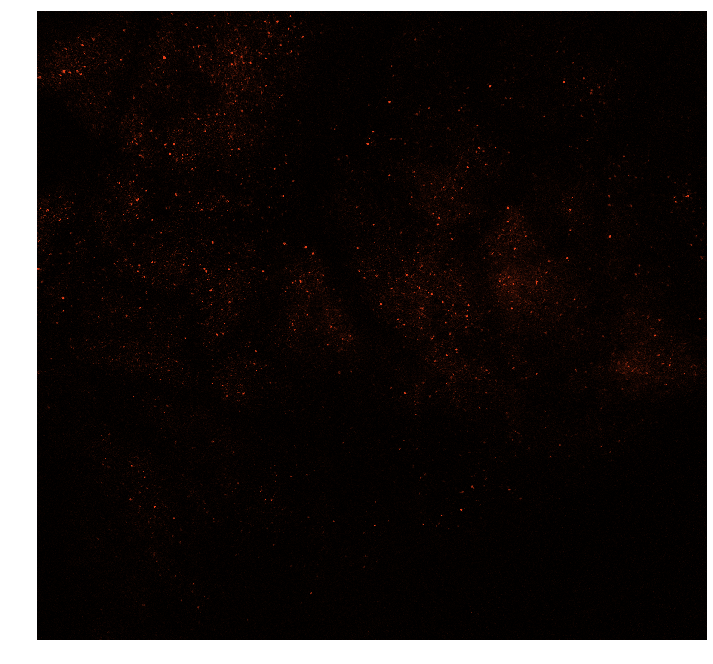

In [212]:
image(mapped_speed, size=12)

In [213]:
imsave(savepath+'/rsqSpeedD.tif', (255*mapped_speed.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [214]:
#mapped_speed = imread(savepath+'/rsqSpeedD.tif', plugin='tifffile').astype('float32')/255

###corridor position maps running

In [215]:
records2 = detrended[np.where(covariates.speed.values>0)].toseries()
records2.cache()

Series
mode: spark
dtype: float64
shape: (1682, 1792, 375)

In [216]:
bins, design_mat = build_reg(covariates.corPos.values[covariates.speed.values>0], 4, debug=True)

bins:
[  0.   4.   8.  12.  16.  20.  24.]
repeats:
[  35.   36.   35.   45.   39.   51.  134.]


In [217]:
tuning_corposR, rsq_corposR = do_reg(records2, design_mat, bins)

In [248]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
mapped_corposR = make_rsq_map(rsq_corposR, vmin=0.02, vmax=0.08, cmap=cmap)

In [219]:
#mapped_corposR = imread(savepath+'/rsqCorPosRD.tif', plugin='tifffile').astype('float32')/255

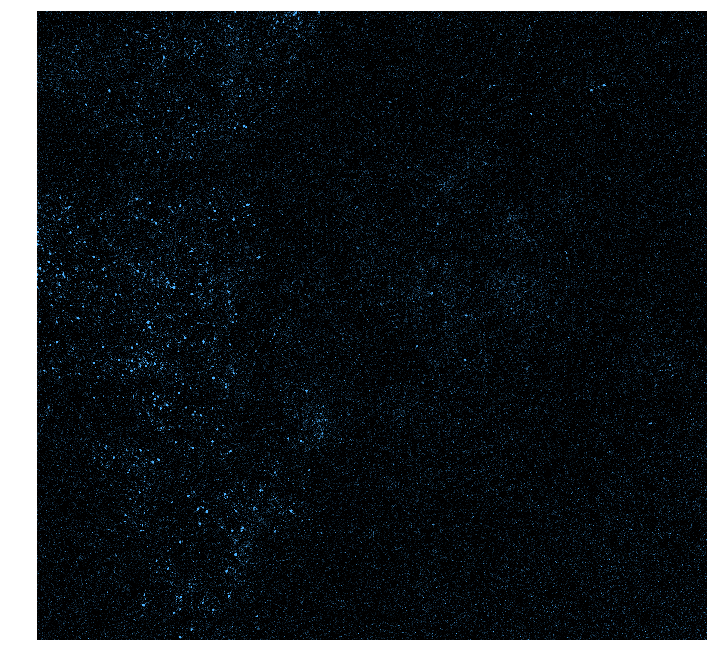

In [249]:
image(mapped_corposR, size=12);

In [250]:
imsave(savepath+'/rsqCorPosRD.tif', (255*mapped_corposR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [251]:
mappedR = make_map(rsq_corposR, tuning_corposR, vmin=10.5, vmax = 13.5, rmin=0.02, rmax=0.08)

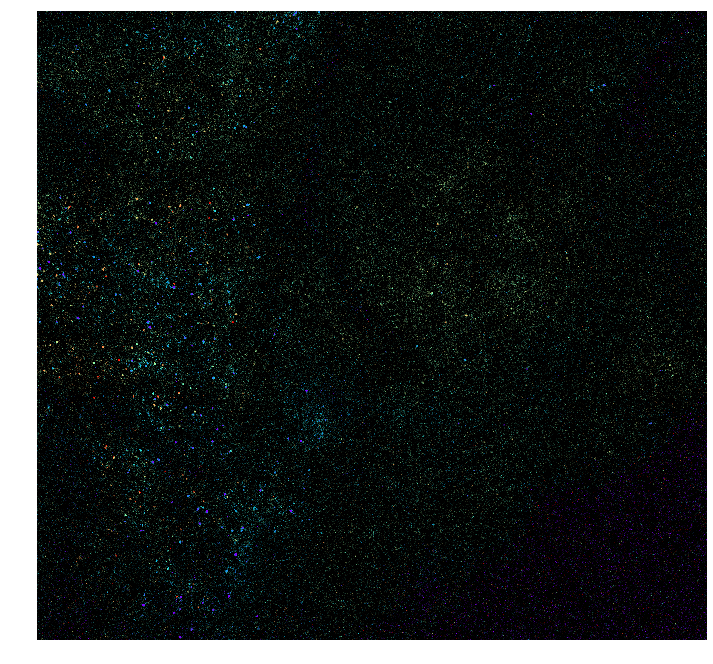

In [252]:
image(mappedR.clip(0,1), size=12);

In [253]:
imsave(savepath+'/tuneCorPosRD.tif', (255*mappedR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

### corridor position maps

In [225]:
bins, design_mat = build_reg(covariates.corPos.values, 4, debug=True)

bins:
[  0.   4.   8.  12.  16.  20.  24.]
repeats:
[  250.   267.   278.   348.   385.   508.  1698.]


In [226]:
tuning_corpos, rsq_corpos = do_reg(records, design_mat, bins)

In [227]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
mapped_corpos = make_rsq_map(rsq_corpos, vmin=0, vmax=0.05, cmap=cmap)

In [228]:
#plt.hist(tuning_corpos[rsq_corpos>.0005].flatten())

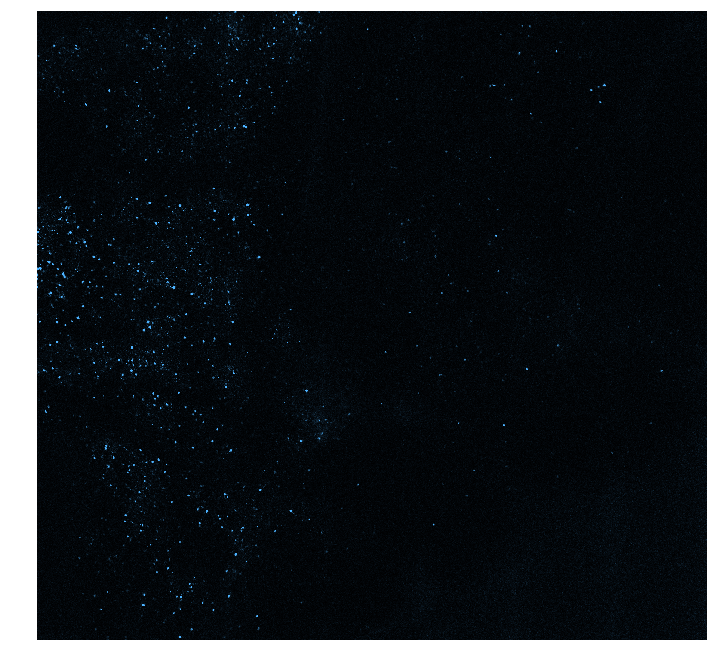

In [229]:
image(mapped_corpos, size=12);

In [230]:
imsave(savepath+'/rsqCorPosAD.tif', (255*mapped_corpos.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [231]:
#mapped_corpos = imread(savepath+'/rsqCorPosAD.tif', plugin='tifffile').astype('float32')/255

In [232]:
mapped = make_map(rsq_corpos, tuning_corpos, vmin=10.5, vmax = 13.5, rmin=0.008, rmax=0.05)

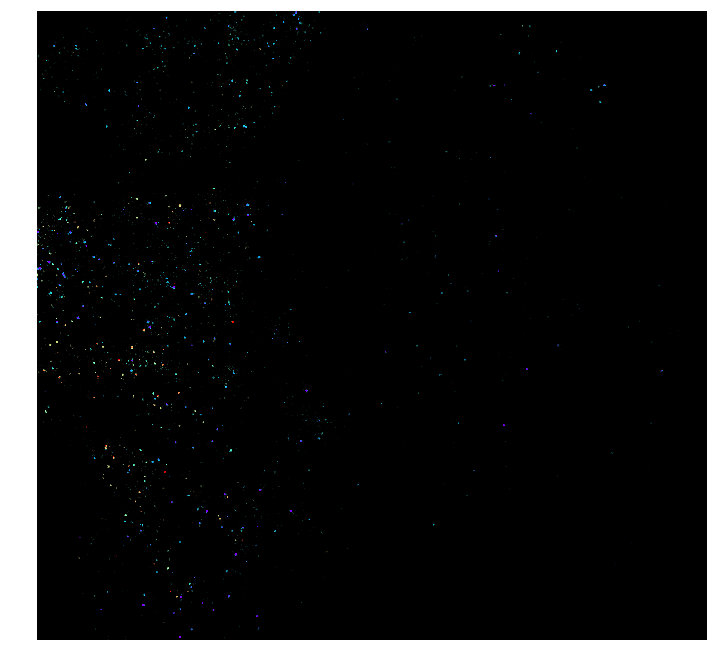

In [233]:
image(mapped.clip(0,1), size=12);

In [234]:
imsave(savepath+'/tuneCorPosAD.tif', (255*mapped.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

/usr/local/python-2.7.6/lib/python2.7/site-packages/scikit_image-0.11.3-py2.7-linux-x86_64.egg/skimage/io/_io.py:159: UserWarning: /tier2/freeman/Nick/lfov.calibration/reprocessed/anm-0330549-6/2016-04-24/summary/tuneCorPosAD.tif is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


###overlay

In [235]:
overlay = maximum(mapped_corpos, mapped_speed)

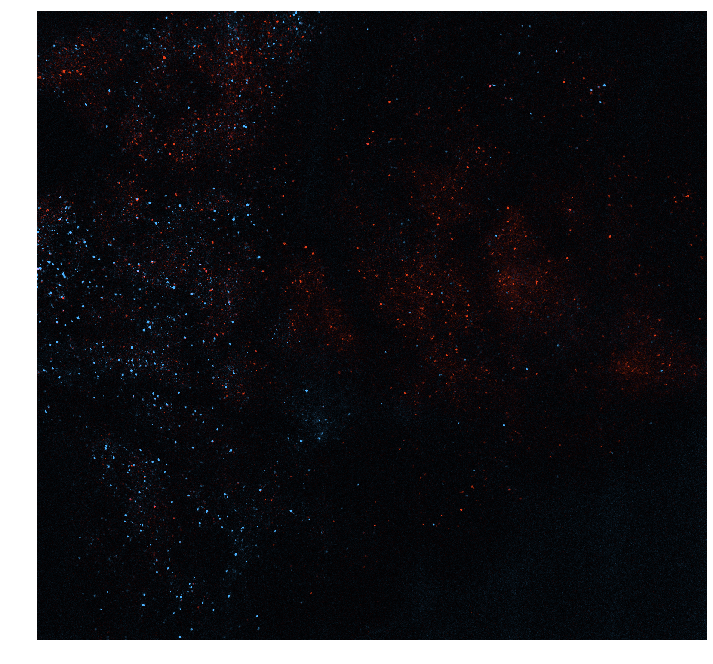

In [236]:
image(overlay, size=12)

In [237]:
imsave(savepath+'/rsqOverlayD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

### localcorr map

In [238]:
localcorr = detrended.localcorr((4, 4)).astype('float32')

In [239]:
imsave(savepath+'/localcorrD.tif', localcorr, plugin='tifffile', photometric='minisblack')

In [240]:
#localcorr = imread(savepath+'/localcorrD.tif')

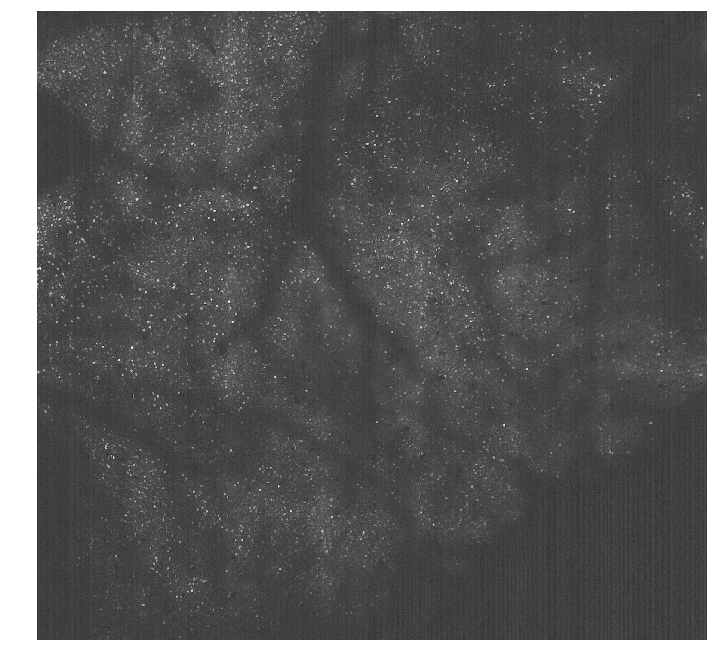

In [241]:
image(localcorr, clim=(0, 3.5*localcorr.mean()), size=12)

In [242]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.1, 1.0, 0.2]])
mapped_localcorr = make_rsq_map(localcorr, vmin=0.4, vmax=0.7, cmap=cmap)

##overlay

In [243]:
overlay = maximum(maximum(mapped_corpos, mapped_speed), mapped_localcorr)

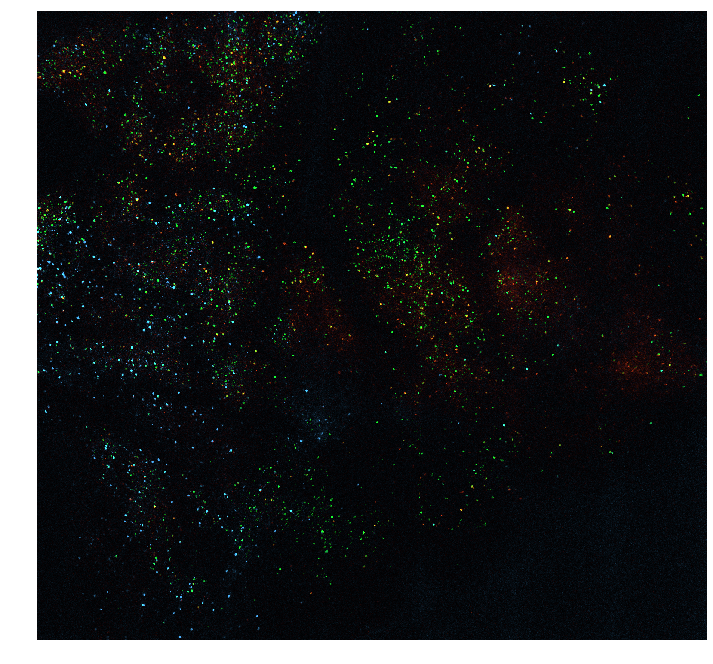

In [244]:
image(overlay, size=12);

In [245]:
imsave(savepath+'/rsqOverlayLCD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

##tuning curves

In [246]:
#plt.plot(betasA[123,10,1,:])

In [247]:
#fig = plt.figure(figsize=[10,10])
#ax = plt.axes()
#im = image(betasA[:,:,0,2] - betasA[:,:,0,5], clim=(-125, 125), ax=ax)